#Майнор ИАД. Домашнее задание 3. YOLO.

В этом задании вы напишете и обучите свой собственный YOLO детектор. Нужно будет разобраться со статьей: понять какого формата должна быть обучающая пара (x, y), как перевести лосс из математической формулы в питоновский код - ну и конечно понять и реализовать саму архитектуру модели.

Выборка на которой мы будем обучать модель состоит из разнообразных фотографий яблок, бананов и апельсинов. Данные скачиваем [отсюда](https://drive.google.com/file/d/1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3/view?usp=sharing).

Баллы за ДЗ распределены следующим образом: 
- Выборка для YoloV1 - 2 балла
- YOLO модель - 2 балла
- YOLO Loss - 3 балла
- Вспомогательные функции - 2 балла
- Обучение и расчет метрик - 2 балла

Для построения и обучения можно использовать как pytorch, так и pytorch-lightning.

Да-да, баллов в сумме получается 11

In [1]:
# Данная библиотека понадобится нам, чтобы обработать разметку
! pip install xmltodict -q pytorch-lightning -q

Скачаем данные

In [ ]:
!wget --quiet --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://drive.google.com/uc?export=download&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1d8GSfZoWbraWCSUhX78yl4CnMFYE-5n3" -O data.zip && rm -rf /tmp/cookies.txt
!unzip -q data.zip
!rm data.zip
!ls -l

total 12
drwx------ 4 root root 4096 Nov 26 08:32 data
drwxr-xr-x 3 root root 4096 Dec 19 16:19 __MACOSX
drwxr-xr-x 1 root root 4096 Dec 16 00:01 sample_data


Посмотрим как выглядит один из файлов разметки

In [2]:
!cat data/train/apple_2.xml

<annotation>
	<folder>train</folder>
	<filename>apple_2.jpg</filename>
	<path>C:\tensorflow1\models\research\object_detection\images\train\apple_2.jpg</path>
	<source>
		<database>Unknown</database>
	</source>
	<size>
		<width>250</width>
		<height>250</height>
		<depth>3</depth>
	</size>
	<segmented>0</segmented>
	<object>
		<name>apple</name>
		<pose>Unspecified</pose>
		<truncated>0</truncated>
		<difficult>0</difficult>
		<bndbox>
			<xmin>37</xmin>
			<ymin>52</ymin>
			<xmax>205</xmax>
			<ymax>222</ymax>
		</bndbox>
	</object>
</annotation>


## Релизуйте выборку для YoloV1 - 2 балла

In [3]:
import os
import cv2
import json
import glob
import tqdm
import xmltodict

from IPython.core.display import struct

from typing import List

import pandas as pd
import numpy as np

import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import pytorch_lightning as pl

import albumentations as A
import albumentations.pytorch

from PIL import Image

import matplotlib.pyplot as plt

from sklearn.metrics import auc
# Добавьте необходимые вам библиотеки, если их не окажется в списке выше

DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

Так как в этом домашнем задании использовать аугментации для обучения __обязательно__ - советуем воспользоваться библиотекой albumentations.

Она  особенно удобна, поскольку умеет сама вычислять новые координаты bounding box'ов после трансформаций картинки. Для знакомства с этим механизмом советуем следующий [гайд](https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/). 

Вы все еще можете избрать путь torchvision.transforms, вам потребуется знакомый нам метод `__getitem__`, однако вычислять новые координаты bounding box'ов после трансформаций вам придётся вручную

__Обратите внимание__ на то, что в статье коробки предсказаний параметризуются через: _(x_center, y_center, width, height)_ (причем эти значения _относительные_), а в наших файлах - это _(x_min, y_min, x_max, y_max)_

Также, помните что модель должна предсказывать как прямоугольник с объектом, так и вероятности каждого класса!

In [4]:
from pprint import pprint
with open("data/train/apple_3.xml", "rt") as xml_file:
    pprint(xmltodict.parse(xml_file.read()))

{'annotation': {'filename': 'apple_3.jpg',
                'folder': 'train',
                'object': [{'bndbox': {'xmax': '867',
                                       'xmin': '584',
                                       'ymax': '708',
                                       'ymin': '438'},
                            'difficult': '0',
                            'name': 'apple',
                            'pose': 'Unspecified',
                            'truncated': '1'},
                           {'bndbox': {'xmax': '740',
                                       'xmin': '492',
                                       'ymax': '394',
                                       'ymin': '141'},
                            'difficult': '0',
                            'name': 'apple',
                            'pose': 'Unspecified',
                            'truncated': '0'},
                           {'bndbox': {'xmax': '490',
                                       'xmin': '176',
  

In [5]:
class2tag = {"apple": 1, "orange": 2, "banana": 3}

class FruitDataset(Dataset):
    def __init__(self, data_dir, S=7, B=2, C=3, transforms=None):
        self.image_paths = sorted(glob.glob(os.path.join(data_dir, "*.jpg")))
        self.box_paths = sorted(glob.glob(os.path.join(data_dir, "*.xml")))

        print(self.image_paths)
        print(self.box_paths, end='\n\n')

        assert len(self.image_paths) == len(self.box_paths)

        self.transforms = transforms

        self.S = S
        self.B = B
        self.C = C

    # Координаты прямоугольников советуем вернуть именно в формате (x_center, y_center, width, height)
    def __getitem__(self, idx):
        image = np.array(Image.open(self.image_paths[idx]).convert("RGB"))
        boxes, class_labels = self.__get_boxes_from_xml(self.box_paths[idx])

        for i, box in enumerate(boxes):
            boxes[i] = self.__convert_to_yolo_box_params(box, image.shape[1], image.shape[0])
            print(image.shape[0], image.shape[1])

        if self.transforms:
            augmentations = self.transforms(image=image, bboxes=boxes, class_labels=class_labels)
            image = augmentations["image"]
            boxes = augmentations["bboxes"]
            class_labels = augmentations["class_labels"]

        target_tensor = torch.zeros((self.S, self.S, 5 * self.B + self.C + 1))

        for box, class_label in zip(boxes, class_labels):
            STATUS_IDX = 0
            x, y, width, height = box

            i, j = int(self.S * y), int(self.S * x)
            x_cell, y_cell = self.S * x - j, self.S * y - i

            width_cell, height_cell = width * self.S, height * self.S

            if target_tensor[i, j, STATUS_IDX] == 0:
                target_tensor[i, j, STATUS_IDX] = 1

                # Including confidence
                target_tensor[i, j, 4:9] = torch.tensor(
                    [x_cell, y_cell, width_cell, height_cell, 1]
                )

                target_tensor[i, j, class_label] = 1

        return torch.tensor(image).to(DEVICE), target_tensor.to(DEVICE)

    def __len__(self):
        return len(self.image_paths)

    def __get_boxes_from_xml(self, xml_filename: str):
        """
        Метод, который считает и распарсит (с помощью xmltodict) переданный xml
        файл и вернет координаты прямоугольников обьектов на соответствующей фотографии
        и название класса обьекта в каждом прямоугольнике

        Обратите внимание, что обьектов может быть как несколько, так и один единственный
        """
        
        boxes = []
        class_labels = []

        with open(xml_filename, "rt") as xml_file:
            box_values = xmltodict.parse(xml_file.read())["annotation"]["object"]
            if isinstance(box_values, list):
                for box in box_values:
                    boxes.append([int(box["bndbox"]["xmin"]), 
                                  int(box["bndbox"]["ymin"]), 
                                  int(box["bndbox"]["xmax"]), 
                                  int(box["bndbox"]["ymax"])])
                    class_labels.append(class2tag[box["name"]])
            elif isinstance(box_values, dict):
                boxes.append([int(box_values["bndbox"]["xmin"]), 
                              int(box_values["bndbox"]["ymin"]), 
                              int(box_values["bndbox"]["xmax"]), 
                              int(box_values["bndbox"]["ymax"])])
                class_labels.append(class2tag[box_values["name"]]) 
            else:
                raise TypeError ("Wrong box storage type after xml_file parse: " + str(type(box_values)))

        return boxes, class_labels

    def __convert_to_yolo_box_params(self, box_coordinates: List[int], im_w, im_h):
        """
        Перейти от [xmin, ymin, xmax, ymax] к [x_center, y_center, width, height].
        
        Обратите внимание, что параметры [x_center, y_center, width, height] - это
        относительные значение в отрезке [0, 1]

        :param: box_coordinates - координаты коробки в формате [xmin, ymin, xmax, ymax]
        :param: im_w - ширина исходного изображения
        :param: im_h - высота исходного изображения

        :return: координаты коробки в формате [x_center, y_center, width, height]
        """
        ans = []

        ans.append((box_coordinates[0] + box_coordinates[2]) / 2 / im_w)  # x_center
        ans.append((box_coordinates[1] + box_coordinates[3]) / 2 / im_h)  # y_center
      
        ans.append((box_coordinates[2] - box_coordinates[0]) / im_w)  # width
        ans.append((box_coordinates[3] - box_coordinates[1]) / im_h)  # height

        return ans


**target_tensor / prediction**
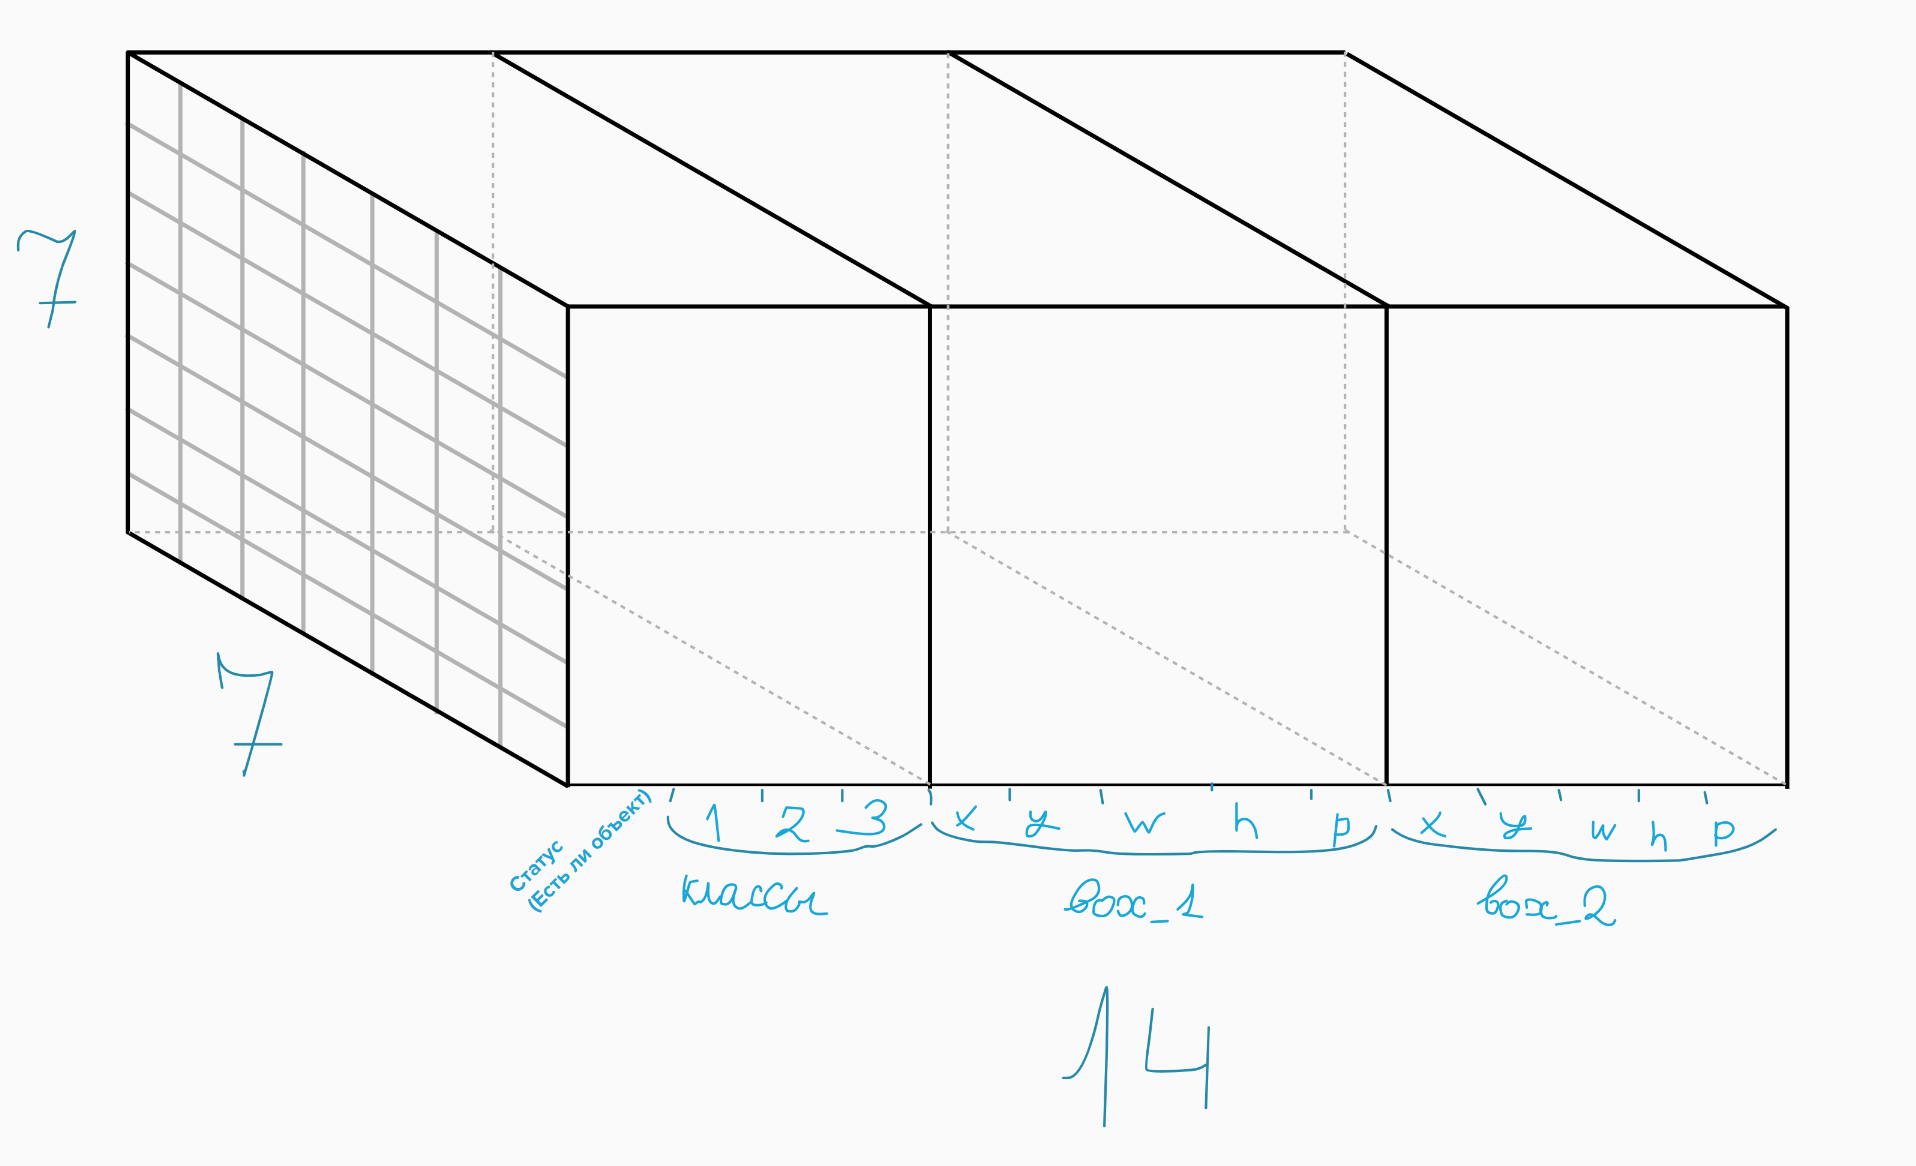

In [6]:
WIDTH, HEIGHT = 448, 448

train_transform = A.Compose([ A.Resize(HEIGHT, WIDTH), A.pytorch.transforms.ToTensorV2()],
                             bbox_params=A.BboxParams(format='yolo',
                                                      label_fields=['class_labels']))
test_transform = A.Compose([A.Resize(HEIGHT, WIDTH), A.pytorch.transforms.ToTensorV2()],
                            bbox_params=A.BboxParams(format='yolo',
                                                     label_fields=['class_labels']))

In [7]:
train_dataset = FruitDataset(
    transforms=train_transform,
    data_dir="./data/train"
    )

val_dataset = FruitDataset(
    transforms=test_transform, 
    data_dir="./data/test"
    )

# Немного проверок, чтобы убедиться в правильности направления решения
assert isinstance(train_dataset[0], tuple)
assert len(train_dataset[0]) == 2
assert isinstance(train_dataset[0][0], torch.Tensor)
print("Тесты успешно пройдены", end='\n\n')

for i in range(1):
    print(train_dataset[i][1])

['./data/train/apple_1.jpg', './data/train/apple_10.jpg', './data/train/apple_11.jpg', './data/train/apple_12.jpg', './data/train/apple_13.jpg', './data/train/apple_14.jpg', './data/train/apple_15.jpg', './data/train/apple_16.jpg', './data/train/apple_17.jpg', './data/train/apple_18.jpg', './data/train/apple_19.jpg', './data/train/apple_2.jpg', './data/train/apple_20.jpg', './data/train/apple_21.jpg', './data/train/apple_22.jpg', './data/train/apple_23.jpg', './data/train/apple_24.jpg', './data/train/apple_25.jpg', './data/train/apple_26.jpg', './data/train/apple_27.jpg', './data/train/apple_28.jpg', './data/train/apple_29.jpg', './data/train/apple_3.jpg', './data/train/apple_30.jpg', './data/train/apple_31.jpg', './data/train/apple_32.jpg', './data/train/apple_33.jpg', './data/train/apple_35.jpg', './data/train/apple_36.jpg', './data/train/apple_37.jpg', './data/train/apple_38.jpg', './data/train/apple_39.jpg', './data/train/apple_4.jpg', './data/train/apple_40.jpg', './data/train/app

<ipython-input-5-7c9ff7331ce1>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image).to(DEVICE), target_tensor.to(DEVICE)


349 349
349 349
Тесты успешно пройдены

349 349
tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0

In [8]:
train_dataloader = DataLoader(
    dataset=train_dataset,
    batch_size= 4,
    shuffle=True)

val_dataloader = DataLoader(
    dataset=val_dataset,
    batch_size=4, 
    shuffle=False
    )

Теперь определим функцию для рассчета Intersection Over Union по 4 углам двух прямоугольников

In [9]:
def intersection_over_union(predicted_bbox, gt_bbox) -> float:
    """
    Intersection Over Union для двух прямоугольников

    :param: predicted_bbox - [x_min, y_min, x_max, y_max]
    :param: gt_bbox - [x_min, y_min, x_max, y_max]
    
    :return: Intersection Over Union
    """

    intersection_bbox = np.array(
        [
            max(predicted_bbox[0], gt_bbox[0]),
            max(predicted_bbox[1], gt_bbox[1]),
            min(predicted_bbox[2], gt_bbox[2]),
            min(predicted_bbox[3], gt_bbox[3]),
        ]
    )

    intersection_area = max(intersection_bbox[2] - intersection_bbox[0], 0) * max(
        intersection_bbox[3] - intersection_bbox[1], 0
    )
    area_dt = (predicted_bbox[2] - predicted_bbox[0]) * (predicted_bbox[3] - predicted_bbox[1])
    area_gt = (gt_bbox[2] - gt_bbox[0]) * (gt_bbox[3] - gt_bbox[1])

    union_area = area_dt + area_gt - intersection_area

    iou = intersection_area / union_area
    return iou

Теперь начинается основная часть домашнего задания: обучите модель YOLO для object detection на __обучающем__ датасете. 

 - Создайте модель и функцию ошибки YoloV1 прочитав [оригинальную статью](https://paperswithcode.com/paper/you-only-look-once-unified-real-time-object)
 - Напишите функцию обучения модели
 - Используйте аугментации

## Реализуйте Модель - 2 балла

Копировать точное количество слоев и параметры сверток необязательно. Главное - чтобы модель работала по принципу, описанному в статье и делала предсказание в представленном формате.


В качестве подсказки напомним, что выходом модели __для каждого обьекта__ должен быть тензор размера
__S * S * (B * 5 + С)__, где все параметры имеют такое же значение, как и в статье: 

- S - количество ячеек на которое разбивается изображение по вертикали/горизонтали
- В - количество предсказываемых прямоугольников в каждой ячейке
- 5 - количество параметров для определения каждого прямоугольника (x_center, y_center, width, height, confidence)
- С - количество классов (apple, banana, orange)

Таким образом, мы для каждого окна размера __S x S__ предсказываем __В__ коробок и один класс

> **Источники идей, вдохновения и кода**:

* https://us06web.zoom.us/rec/play/3lfnRVT2KiKsqF-c-OkX2cR8B-bMa2Gszp2V0U_u1li2B2C4IDHoYybxGklO0GDrFTCHsHjHFen5e4Vg.Hiaz7q2g8zGsd23S?autoplay=true&startTime=1670515472000 (консультация)

* https://albumentations.ai/docs/getting_started/bounding_boxes_augmentation/ (transforms)

* https://www.youtube.com/watch?v=n9_XyCGr-MI + [Плейлист](https://www.youtube.com/playlist?list=PLhhyoLH6Ijfw0TpCTVTNk42NN08H6UvNq) (implementation)

* https://blog.flaport.net/yolo-part-2.html (loss function)

* https://towardsdatascience.com/non-maximum-suppression-nms-93ce178e177c (NMS)

* https://habr.com/ru/company/jetinfosystems/blog/498294/ (NMS)

* https://www.kaggle.com/code/vexxingbanana/yolov1-from-scratch-pytorch (implementation)

In [10]:
class CNNBlock(pl.LightningModule):  # можно поменять на Lightning
    def __init__(self, in_channels, out_channels, is_max_pool:bool=False, **kwargs):
        
        super().__init__()

        self.conv = nn.Conv2d(in_channels, out_channels, **kwargs, device=DEVICE)
        self.batchnorm = nn.BatchNorm2d(out_channels, device=DEVICE)  # в статье еще не знали про батчнорм, но мы то из будущего ...
        self.leakyrelu = nn.LeakyReLU(0.1)

        self.is_maxpool = is_max_pool  # не после каждой свертки нужно делать maxpool
        self.maxpool = nn.MaxPool2d(2, stride=2)
        
    def forward(self, x):
        print("CNN_forward, shape=", x.shape, sep='')
        x = self.leakyrelu(self.batchnorm(self.conv(x.to(DEVICE))))

        if self.is_maxpool:
            x = self.maxpool(x)

        return x
    
class YOLO(pl.LightningModule):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()

        self.S = S
        self.B = B
        self.C = C

        self.conv = [CNNBlock(3, 192, is_max_pool=True, stride=2, kernel_size=(7, 7)),
            CNNBlock(192, 128, is_max_pool=True, kernel_size=(3, 3)),
            CNNBlock(128, 256, is_max_pool=False, kernel_size=(1, 1)),
            CNNBlock(256, 32, is_max_pool=False, kernel_size=(5, 5)),
            CNNBlock(32, 128, is_max_pool=False, kernel_size=(1, 1)),
            CNNBlock(128, 256, is_max_pool=True, kernel_size=(3, 3)),

            CNNBlock(256, 128, is_max_pool=False, kernel_size=(3, 3)),
            CNNBlock(128, 256, is_max_pool=False, kernel_size=(3, 3)),
            CNNBlock(256, 64, is_max_pool=False, kernel_size=(3, 3)),
            CNNBlock(64, 32, is_max_pool=False, kernel_size=(3, 3)),
            CNNBlock(32, 32, is_max_pool=False, kernel_size=(1, 1)),
            CNNBlock(32, 1024, is_max_pool=True, kernel_size=(3, 3)),
            CNNBlock(1024, 1024, is_max_pool=False, kernel_size=(1, 1)),
        ]

        self.fc1 = nn.Linear(7*7*1024, 4096)
        self.fc2 = nn.Linear(4096, 7*7*14)     


    def forward(self, x):
        print("YOLO_forward")
        
        for cnn in self.conv:
            x = cnn(x)
        print(x.shape)
        x = nn.Flatten()(x)
        return self.fc2(self.fc1(x))


# Убедитесь на одном изображении, что предсказания вашей модели имеют верное количество значений

testing_model = YOLO().to(DEVICE)
expected_output_shape = testing_model.S * testing_model.S * (5 * testing_model.B + testing_model.C + 1)

testing_image = torch.tensor(train_dataset[0][0].clone().detach(), dtype=torch.float32).unsqueeze(0)
testing_image = torch.reshape(testing_image, (1, 3, 448, 448)).to(DEVICE)
print(testing_image.shape)

model = testing_model(testing_image)

print("GOAL:", expected_output_shape)
print("RESULT:", model.reshape(-1).shape[0])

assert model.reshape(-1).shape[0] == expected_output_shape

349 349
torch.Size([1, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([1, 3, 448, 448])


<ipython-input-5-7c9ff7331ce1>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image).to(DEVICE), target_tensor.to(DEVICE)
<ipython-input-10-d2fd6dfc6163>:71: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  testing_image = torch.tensor(train_dataset[0][0].clone().detach(), dtype=torch.float32).unsqueeze(0)


CNN_forward, shape=torch.Size([1, 192, 110, 110])
CNN_forward, shape=torch.Size([1, 128, 54, 54])
CNN_forward, shape=torch.Size([1, 256, 54, 54])
CNN_forward, shape=torch.Size([1, 32, 50, 50])
CNN_forward, shape=torch.Size([1, 128, 50, 50])
CNN_forward, shape=torch.Size([1, 256, 24, 24])
CNN_forward, shape=torch.Size([1, 128, 22, 22])
CNN_forward, shape=torch.Size([1, 256, 20, 20])
CNN_forward, shape=torch.Size([1, 64, 18, 18])
CNN_forward, shape=torch.Size([1, 32, 16, 16])
CNN_forward, shape=torch.Size([1, 32, 16, 16])
CNN_forward, shape=torch.Size([1, 1024, 7, 7])
torch.Size([1, 1024, 7, 7])
GOAL: 686
RESULT: 686


## Реализуйте YoloLoss - 3 балла

In [11]:
def intersection_over_union(boxes_preds, boxes_labels):
    print("boxes_preds:", boxes_preds.shape)
    print("boxes_labels:", boxes_labels.shape)

    box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
    box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
    box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
    box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
    box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
    box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
    box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
    box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    print("box1_x1:", box1_x1.shape)
    print("box2_x1:", box2_x1.shape)
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)
    
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)
    
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    # print("iou: out_shape=", (intersection / (box1_area + box2_area - intersection + 1e-6)).shape, sep='')
    
    return intersection / (box1_area + box2_area - intersection + 1e-6)

In [13]:
class YoloLoss(nn.Module):
    def __init__(self, S=7, B=2, C=3):
        """
        :param: S * S - количество ячеек на которые разбивается изображение
        :param: B - количество предсказанных прямоугольников в каждой ячейке
        :param: C - количество классов
        """
        
        super().__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # print(predictions, target)
        
        predictions = predictions.reshape(-1, self.S, self.S, self.C + self.B * 5 + 1)
        target = target.unsqueeze(0)
        
        print("predictions:", predictions.shape)
        print("target:", target.shape)

        iou_b1 = intersection_over_union(predictions[..., self.C + 1:self.C + 5], target[..., self.C + 1:self.C + 5])
        iou_b2 = intersection_over_union(predictions[..., self.C + 6:self.C + 10], target[..., self.C + 1:self.C + 5])


        # print(iou_b1.shape)
        # print(iou_b2.shape)

        # print(iou_b1.unsqueeze(0).shape)
        # print(iou_b2.unsqueeze(0).shape)

        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)

        print("ious:", ious.shape)


        iou_maxes, indices = torch.max(ious, dim=0)
        exists_box = target[..., 0]
        print(exists_box.shape)
        exists_box = exists_box.squeeze(0)
        print(exists_box.shape)
        exists_box = exists_box.unsqueeze(3)
        print("exists_box:", exists_box.shape)

        print("iou_maxes:", iou_maxes.shape)
        print("indices:", indices.shape)


        print("predictions[...]:", predictions[..., self.C + 6:self.C + 10].shape)
        box_predictions = exists_box * (
            (
                indices * predictions[..., self.C + 6:self.C + 10]
                + (1 - indices) * predictions[..., self.C + 1:self.C + 5]
            )
        )

        box_targets = exists_box * target[..., self.C + 1:self.C + 5]

        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )


        pred_box = (
            indices * predictions[..., self.C + 10:self.C + 11] + (1 - indices) * predictions[..., self.C + 5:self.C + 6]
        )

        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., self.C + 5:self.C + 6]),
        )

        
        print("exists_box:", exists_box.shape)
        print("flatten_predictions[...]:", torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=1).shape)
        print("flatten_target[...]:", torch.flatten((1 - exists_box) * target[..., self.C + 5:self.C + 6], start_dim=1).shape)
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 5:self.C + 6], start_dim=0),
            torch.flatten((1 - exists_box) * target[..., self.C + 5:self.C + 6], start_dim=1),
        )

        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., self.C + 10:self.C + 11], start_dim=0),
            torch.flatten((1 - exists_box) * target[..., self.C + 5:self.C + 6], start_dim=1)
        )



        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., 1:self.C + 1], end_dim=-2,),
            torch.flatten(exists_box * target[..., 1:self.C + 1], end_dim=-2,),
        )

        print("BOX LOSS:", box_loss)
        print("BOX MULTIPLIED LOSS:", self.lambda_coord * box_loss)
        print("OBJECT LOSS:", object_loss)
        print("NO_OBJECT LOSS:", no_object_loss)
        print("NO_OBJECT MULTIPLIED LOSS:", self.lambda_noobj * no_object_loss)
        print("CLASS LOSS:", class_loss)


        loss = (
            self.lambda_coord * box_loss +
            object_loss + 
            self.lambda_noobj * no_object_loss + 
            class_loss  
        )

        return loss

In [ ]:
_target = torch.zeros(7, 7, 14)
_pred = torch.ones(7, 7, 14)
YoloLoss()(_pred, _target)

## Реализуйте дополнительные функции из статьи - 2 балла

In [14]:
from collections import Counter

def non_max_suppression(bboxes: list, iou_threshold: float, threshold: float):
    bboxes = [box for box in bboxes if box[-1] >= threshold]
    bboxes = sorted(bboxes, key=lambda x: x[-1], reverse=True)

    result = []

    result.append(bboxes.pop(0))
    while bboxes:
        bbox = bboxes.pop(0)
        
        for chosen_box in result:
            if bbox[-2] == chosen_box[-2] and \
                    intersection_over_union(bbox[:-2], chosen_box[:-2]) >= iou_threshold:
                break
        else:
            result.append(bbox)
        
    return result

def mean_average_precision(pred_boxes, true_boxes, iou_threshold=0.5):

    average_precisions = []

    epsilon = 1e-6

    for c in range(3):

        detections = []
        ground_truths = []

        for detection in pred_boxes:
            if detection[1] == c:
                detections.append(detection)

        for true_box in true_boxes:
            if true_box[1] == c:
                ground_truths.append(true_box)

        amount_bboxes = Counter([gt[0] for gt in ground_truths])

        for key, val in amount_bboxes.items():
            amount_bboxes[key] = torch.zeros(val)

        detections.sort(key=lambda x: x[2], reverse=True)
        TP = torch.zeros((len(detections)))
        FP = torch.zeros((len(detections)))
        total_true_bboxes = len(ground_truths)

        if total_true_bboxes == 0:
            continue

        for detection_idx, detection in enumerate(detections):

            ground_truth_img = [
                bbox for bbox in ground_truths if bbox[0] == detection[0]
            ]

            num_gts = len(ground_truth_img)
            best_iou = 0

            for idx, gt in enumerate(ground_truth_img):
                iou = intersection_over_union(
                    torch.tensor(detection[3:]),
                    torch.tensor(gt[3:])
                )

                if iou > best_iou:
                    best_iou = iou
                    best_gt_idx = idx

            if best_iou > iou_threshold:

                if amount_bboxes[detection[0]][best_gt_idx] == 0:
                    TP[detection_idx] = 1
                    amount_bboxes[detection[0]][best_gt_idx] = 1
                else:
                    FP[detection_idx] = 1

            else:
                FP[detection_idx] = 1

        TP_cumsum = torch.cumsum(TP, dim=0)
        FP_cumsum = torch.cumsum(FP, dim=0)
        recalls = TP_cumsum / (total_true_bboxes + epsilon)
        precisions = torch.divide(TP_cumsum, (TP_cumsum + FP_cumsum + epsilon))
        precisions = torch.cat((torch.tensor([1]), precisions))
        recalls = torch.cat((torch.tensor([0]), recalls))
        average_precisions.append(torch.trapz(precisions, recalls))

    return sum(average_precisions) / len(average_precisions)

def get_bound_boxes(loader, model, iou_threshold=.5, threshold=.4):
    all_pred_boxes, all_true_boxes = [], []

    model.eval()
    train_idx = 0

    for batch_idx, (x, labels) in enumerate(loader):
        x = x.to(device)
        labels = labels.to(device)

        with torch.no_grad():
            predictions = model(x)

        batch_size = x.shape[0]
        true_bboxes = cellboxes_to_boxes(labels)
        bboxes = cellboxes_to_boxes(predictions)

        for idx in range(batch_size):
            nms_boxes = non_max_suppression(
                bboxes[idx],
                iou_threshold=iou_threshold,
                threshold=threshold
            )

            for nms_box in nms_boxes:
                all_pred_boxes.append([train_idx] + nms_box)

            for box in true_bboxes[idx]:
                if box[1] > threshold:
                    all_true_boxes.append([train_idx] + box)

            train_idx += 1

    model.train()

    return all_pred_boxes, all_true_boxes


def convert_cellboxes(predictions, S=7, C=3):
    predictions = predictions.to("cpu")
    batch_size = predictions.shape[0]
    predictions = predictions.reshape(batch_size, 7, 7, C + 10)
    bboxes1 = predictions[..., C + 1:C + 5]
    bboxes2 = predictions[..., C + 6:C + 10]
    scores = torch.cat(
        (predictions[..., C].unsqueeze(0), predictions[..., C + 5].unsqueeze(0)), dim=0
    )
    best_box = scores.argmax(0).unsqueeze(-1)
    best_boxes = bboxes1 * (1 - best_box) + best_box * bboxes2
    cell_indices = torch.arange(7).repeat(batch_size, 7, 1).unsqueeze(-1)
    x = 1 / S * (best_boxes[..., :1] + cell_indices)
    y = 1 / S * (best_boxes[..., 1:2] + cell_indices.permute(0, 2, 1, 3))
    w_y = 1 / S * best_boxes[..., 2:4]
    converted_bboxes = torch.cat((x, y, w_y), dim=-1)
    predicted_class = predictions[..., :C].argmax(-1).unsqueeze(-1)
    best_confidence = torch.max(predictions[..., C], predictions[..., C + 5]).unsqueeze(
        -1
    )
    converted_preds = torch.cat(
        (predicted_class, best_confidence, converted_bboxes), dim=-1
    )

    return converted_preds


def cellboxes_to_boxes(out, S=7):
    converted_pred = convert_cellboxes(out).reshape(out.shape[0], S * S, -1)
    converted_pred[..., 0] = converted_pred[..., 0].long()
    all_bboxes = []

    for ex_idx in range(out.shape[0]):
        bboxes = []

        for bbox_idx in range(S * S):
            bboxes.append([x.item() for x in converted_pred[ex_idx, bbox_idx, :]])
        all_bboxes.append(bboxes)

    return all_bboxes

## Обучите модель и посчитайте метрики для задачи детекции - 2 балла 

Несмотря на то, что в этом блоке ничего сильно нового для вас не ожидается и за него формально дается лишь два балла - провести обучение очень важно для понимания того, насколько правильно реализована ваша модель и лосс.

В процессе обучения будет видно все ли размерности совпадают, падает ли лосс и растут ли метрики целевой задачи, поэтому на практике этот пункт гораздо оказывается гораздо важнее.

In [15]:
class YOLOLearner(pl.LightningModule):
    def __init__(self, model) -> None:
        super().__init__()

        self.model = model
        self.loss = YoloLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-3)

    def forward(self, x) -> torch.Tensor:
        return self.model(x)

    def configure_optimizers(self):
        return self.optimizer

    def training_step(self, train_batch, batch_idx) -> torch.Tensor:
        data, target = train_batch        
        data = torch.tensor(data, dtype=torch.float32).to(device)
        target = target.to(device)
        print("data_INITIAL_SHAPE:", data.shape)
        print("target_INITIAL_SHAPE:", target.shape)
        data = torch.reshape(data, (-1, 3, 448, 448))
        print("data_NEXT_SHAPE:", data.shape)
        print("target_NEXT_SHAPE:", data.shape)
        output = self.model(data)
        loss = self.loss(output, target)
        self.log("train_loss", loss, prog_bar=True)
        print("FINAL LOSS:", loss)
        return loss

    def validation_step(self, val_batch, batch_idx) -> None:
        data, target = val_batch
        data = torch.tensor(data, dtype=torch.float32).to(device)
        target = target.to(device)
        print("data_INITIAL_SHAPE:", data.shape)
        print("target_INITIAL_SHAPE:", target.shape)
        data = torch.reshape(data, (-1, 3, 448, 448))
        print("data_NEXT_SHAPE:", data.shape)
        output = self.model(data)
        loss = self.loss(output, target)

        self.log("val_loss", loss, prog_bar=True)


In [16]:
model = YOLO().to(DEVICE)

In [17]:
n_epochs = 10

yolo_learner = YOLOLearner(model)

device = "cuda" if torch.cuda.is_available() else "cpu"
trainer = pl.Trainer(accelerator=device, max_epochs=n_epochs)

trainer.fit(yolo_learner, train_dataloader, val_dataloader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type     | Params
-----------------------------------
0 | model | YOLO     | 208 M 
1 | loss  | YoloLoss | 0     
-----------------------------------
208 M     Trainable params
0         Non-trainable params
208 M     Total params
833.342   Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

<ipython-input-5-7c9ff7331ce1>:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(image).to(DEVICE), target_tensor.to(DEVICE)
<ipython-input-15-5d9ec011ad9b>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).to(device)
/usr/local/lib/python3.8/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 196])) that is different to the input size (torch.Size([196])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

Training: 0it [00:00, ?it/s]

393 600
393 600
416 800
416 800
416 800
600 800
600 800
600 800
600 800
600 800
600 800
600 800
293 300
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
target_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
targ

<ipython-input-15-5d9ec011ad9b>:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  data = torch.tensor(data, dtype=torch.float32).to(device)


250 250
250 250
408 780
1088 1292
1088 1292
387 620
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
target_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.

/usr/local/lib/python3.8/dist-packages/PIL/Image.py:959: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


720 720
500 500
500 500
350 625
350 625
350 625
350 625
1696 1132
1696 1132
1696 1132
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
target_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1,

Validation: 0it [00:00, ?it/s]

229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

Validation: 0it [00:00, ?it/s]

229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

Validation: 0it [00:00, ?it/s]

229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

Validation: 0it [00:00, ?it/s]

229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

Validation: 0it [00:00, ?it/s]

229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

Validation: 0it [00:00, ?it/s]

229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

Validation: 0it [00:00, ?it/s]

229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

Validation: 0it [00:00, ?it/s]

229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

Validation: 0it [00:00, ?it/s]

229 300
229 300
229 300
229 300
229 300
350 350
720 720
500 600
data_INITIAL_SHAPE: torch.Size([4, 3, 448, 448])
target_INITIAL_SHAPE: torch.Size([4, 7, 7, 14])
data_NEXT_SHAPE: torch.Size([4, 3, 448, 448])
YOLO_forward
CNN_forward, shape=torch.Size([4, 3, 448, 448])
CNN_forward, shape=torch.Size([4, 192, 110, 110])
CNN_forward, shape=torch.Size([4, 128, 54, 54])
CNN_forward, shape=torch.Size([4, 256, 54, 54])
CNN_forward, shape=torch.Size([4, 32, 50, 50])
CNN_forward, shape=torch.Size([4, 128, 50, 50])
CNN_forward, shape=torch.Size([4, 256, 24, 24])
CNN_forward, shape=torch.Size([4, 128, 22, 22])
CNN_forward, shape=torch.Size([4, 256, 20, 20])
CNN_forward, shape=torch.Size([4, 64, 18, 18])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 32, 16, 16])
CNN_forward, shape=torch.Size([4, 1024, 7, 7])
torch.Size([4, 1024, 7, 7])
predictions: torch.Size([4, 7, 7, 14])
target: torch.Size([1, 4, 7, 7, 14])
boxes_preds: torch.Size([4, 7, 7, 4])
boxes_labels: tor

/usr/local/lib/python3.8/dist-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")


## Посчитайте метрики задачи детекции на валидационной выборке

Попробуйте понять насколько хороши ваши показатели. Если числа кажутся подозрительно низкими - возможно вам стоит перепроверить ваше решение. 

In [ ]:
## YOUR CODE

## Визуализируйте предсказанные bounding box'ы для любых пяти картинок из __валидационного__ датасета.

In [ ]:
image, targets = next(iter(val_dataset))
preds = ## YOUR CODE

In [ ]:
from PIL import ImageDraw

image = torchvision.transform.ToPILImage()(image)
draw = ImageDraw.Draw(image)

for box in targets[0]:
    ## YOUR CODE
    draw.rectangle([(box[0], box[1]), (box[2], box[3])])

for box in preds[0]:
    ## YOUR CODE
    draw.rectangle([(box[0], box[1]), (box[2], box[3])], outline='red')
image